In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Zillow

Data provided by Zillow * Kaggle (see [here](https://www.kaggle.com/pratyushakar/zillow-zestimate#properties_2017.csv))

In [2]:
data_url = "https://docs.google.com/spreadsheets/d/198EG3tckqzD1uOKSYxAY62i5v_0LIZQMgzaIae6u1vo/export?format=csv"

<IPython.core.display.Javascript object>

Load all the usual suspects and some new ones including: `AgglomerativeClustering`, `DBSCAN`, `dendrogram`.

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

Function that will also be used in your exercise to produce a dendrogram from our `AgglomerativeClustering` object.

In [4]:
def plot_dendrogram(model, **kwargs):
    """
    A function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    
    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.
    
    Output: a dendrogram based on the model based in the parameters.
    
    Returns: None   
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(
        float
    )

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

<IPython.core.display.Javascript object>

Read data and do some inspection & cleaning.

In [5]:
zillow = pd.read_csv(data_url)
zillow.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,17291058,NaN,NaN,8516.0,9.5,6,NaN,NaN,9.5,66.0,...,2.0,NaN,12956457,26879210,2016,13922753,283062.46,NaN,NaN,6.111007e+13
1,17214945,NaN,NaN,296.0,2.5,3,NaN,NaN,2.5,66.0,...,2.0,NaN,321000,1074000,2016,753000,11525.74,NaN,NaN,6.111005e+13
2,17060678,NaN,NaN,1146.0,6.5,4,NaN,NaN,6.5,66.0,...,2.0,NaN,1804157,2275709,2016,471552,24503.28,NaN,NaN,6.111001e+13
3,17284901,NaN,NaN,2322.0,1.5,6,NaN,NaN,1.5,66.0,...,3.0,NaN,4481348,7138171,2016,2656823,75722.34,NaN,NaN,6.111007e+13
4,17277746,NaN,NaN,182.0,3.5,4,NaN,NaN,3.5,66.0,...,2.0,NaN,254934,420023,2016,165089,4427.28,NaN,NaN,6.111006e+13


<IPython.core.display.Javascript object>

Drop columns that have more than 20% of their values missing.  How many columns does this remove?

In [6]:
perc_na = zillow.isna().mean()
cols_over_20 = perc_na > 0.2
cols_over_20

parcelid                        False
airconditioningtypeid            True
architecturalstyletypeid         True
basementsqft                     True
bathroomcnt                     False
bedroomcnt                      False
buildingclasstypeid              True
buildingqualitytypeid            True
calculatedbathnbr               False
decktypeid                       True
finishedfloor1squarefeet        False
calculatedfinishedsquarefeet    False
finishedsquarefeet12            False
finishedsquarefeet13             True
finishedsquarefeet15             True
finishedsquarefeet50            False
finishedsquarefeet6              True
fips                            False
fireplacecnt                    False
fullbathcnt                     False
garagecarcnt                    False
garagetotalsqft                 False
hashottuborspa                   True
heatingorsystemtypeid            True
latitude                        False
longitude                       False
lotsizesquar

<IPython.core.display.Javascript object>

In [7]:
zillow = zillow.loc[:, ~cols_over_20]
zillow

,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet50,fips,fireplacecnt,...,regionidzip,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,17291058,9.5,6,9.5,10020.0,18117,18117.0,20618.0,6111,9.0,...,96385,21,1992.0,2.0,12956457,26879210,2016,13922753,283062.46,6.111007e+13
1,17214945,2.5,3,2.5,2878.0,4374,4374.0,2878.0,6111,1.0,...,97091,9,1983.0,2.0,321000,1074000,2016,753000,11525.74,6.111005e+13
2,17060678,6.5,4,6.5,4396.0,7051,7051.0,4396.0,6111,9.0,...,97098,10,1996.0,2.0,1804157,2275709,2016,471552,24503.28,6.111001e+13
3,17284901,1.5,6,1.5,10245.0,13513,13513.0,10245.0,6111,5.0,...,96385,19,1991.0,3.0,4481348,7138171,2016,2656823,75722.34,6.111007e+13
4,17277746,3.5,4,3.5,1461.0,2380,2380.0,1461.0,6111,1.0,...,96351,8,1981.0,2.0,254934,420023,2016,165089,4427.28,6.111006e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,17217126,3.0,4,3.0,1691.0,3243,3243.0,1691.0,6111,2.0,...,96385,9,1997.0,2.0,404079,651820,2016,247741,6974.54,6.111008e+13
14996,17239446,2.0,4,2.0,1612.0,1612,1612.0,1612.0,6111,1.0,...,97116,7,1964.0,1.0,125889,167823,2016,41934,3627.60,6.111008e+13
14997,17239945,2.0,3,2.0,1458.0,1458,1458.0,1458.0,6111,1.0,...,97116,6,1964.0,1.0,182745,522853,2016,340108,5990.92,6.111008e+13
14998,10796209,2.0,4,2.0,NaN,1856,1856.0,NaN,6037,NaN,...,96389,0,1960.0,NaN,147000,735000,2016,588000,9037.97,6.037137e+13


<IPython.core.display.Javascript object>

Drop all NAs from the dataframe.  How many rows does this remove?

In [8]:
zillow = zillow.dropna()
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12425 entries, 0 to 14997
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      12425 non-null  int64  
 1   bathroomcnt                   12425 non-null  float64
 2   bedroomcnt                    12425 non-null  int64  
 3   calculatedbathnbr             12425 non-null  float64
 4   finishedfloor1squarefeet      12425 non-null  float64
 5   calculatedfinishedsquarefeet  12425 non-null  int64  
 6   finishedsquarefeet12          12425 non-null  float64
 7   finishedsquarefeet50          12425 non-null  float64
 8   fips                          12425 non-null  int64  
 9   fireplacecnt                  12425 non-null  float64
 10  fullbathcnt                   12425 non-null  float64
 11  garagecarcnt                  12425 non-null  float64
 12  garagetotalsqft               12425 non-null  float64
 13  l

<IPython.core.display.Javascript object>

For the sake of time & plotting, downsample to 100 random records in the `zillow` dataframe.  Use a random seed of `42` to obtain consistent results.

In [9]:
# If we calc a distance matrix it will be 12425 * 12425 (154,380,625) elements large
# Let's down sample to have a quicker demo and a prettier dendrogram to look at
zillow = zillow.sample(100, random_state=42)
zillow.shape

(100, 34)

<IPython.core.display.Javascript object>

Dropping a lot of columns based on being ID, having 0 variance, or being collinear (based on my understanding... rather than analysis... might be wrong).

In [10]:
# Id columns aren't too useful for clustering but we might want them later
# fmt: off
id_cols = ["parcelid", "pooltypeid7", "propertycountylandusecode", 
           "propertylandusetypeid", "regionidcity", "regionidcounty", "regionidzip",
           "latitude", "longitude", "fips",
           "rawcensustractandblock", "censustractandblock"]
zillow_sub = zillow.drop(columns=id_cols)

# Some columns that duplicate info
# Idk much about real estate so some of these might be bad assumptions
dup_cols = ["calculatedbathnbr", "finishedsquarefeet50", "finishedsquarefeet12",
            "finishedfloor1squarefeet", "structuretaxvaluedollarcnt", 
            "taxvaluedollarcnt", "landtaxvaluedollarcnt"]
# fmt: on
zillow_sub = zillow_sub.drop(columns=dup_cols)

# My random sample (using 42 as seed) had 0 variance in these 2 columns
no_var_cols = ["poolcnt", "assessmentyear"]
zillow_sub = zillow_sub.drop(columns=no_var_cols)

zillow_sub.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
11325,4.0,5,3705,2.0,4.0,4.0,948.0,59349.0,684.0,10,2001.0,2.0,15108.92
1766,3.0,5,3642,2.0,3.0,2.0,471.0,7720.0,640.0,10,1998.0,2.0,8078.32
14591,3.0,3,2779,2.0,3.0,2.0,659.0,11610.0,420.0,8,1988.0,2.0,7340.82
14939,3.0,3,2902,2.0,3.0,3.0,774.0,43560.0,525.0,7,1977.0,2.0,11795.98
12049,3.0,4,2295,2.0,3.0,2.0,487.0,8539.0,396.0,8,1979.0,2.0,4799.22


<IPython.core.display.Javascript object>

## Heirarchical Clustering

Links:
* [Greate resource here explaining an example in depth](http://www.econ.upf.edu/~michael/stanford/maeb7.pdf)
* [StatQuest video](https://www.youtube.com/watch?v=7xHsRkOdVwo): admittedly not his best work and not his best "bams"

Prep data for clustering

In [11]:
scaler = StandardScaler()
scaled = scaler.fit_transform(zillow_sub)
scaled_df = pd.DataFrame(scaled, index=zillow_sub.index, columns=zillow_sub.columns)
scaled_df


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
11325,0.641759,1.120951,0.292137,0.321897,0.950019,1.626534,1.062755,0.675226,1.048651,0.921299,1.213299,0.816497,0.624734
1766,-0.255806,1.120951,0.256025,0.321897,0.036539,-0.432370,-0.706772,-0.512082,0.729471,0.921299,1.005897,0.816497,-0.178307
14591,-0.255806,-1.315899,-0.238646,0.321897,0.036539,-0.432370,-0.009348,-0.422624,-0.866428,-0.195427,0.314559,0.816497,-0.262544
14939,-0.255806,-1.315899,-0.168142,0.321897,0.036539,0.597082,0.417267,0.312127,-0.104749,-0.753790,-0.445913,0.816497,0.246328
12049,-0.255806,-0.097474,-0.516074,0.321897,0.036539,-0.432370,-0.647417,-0.493248,-1.040527,-0.195427,-0.307646,0.816497,-0.552848
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,1.090542,-0.097474,0.159155,-0.916167,0.950019,-0.432370,-0.142898,0.300675,1.832093,-0.195427,-2.035991,-1.224745,0.303116
5163,-0.704589,-0.097474,-0.372201,0.321897,-0.876941,-0.432370,-0.061284,-0.001666,-0.648806,-0.195427,0.383693,-1.224745,-0.366903
4317,1.090542,-0.097474,1.135313,0.321897,0.950019,1.626534,0.981142,1.384129,1.309798,0.362936,1.420700,-1.224745,0.863399
9151,-0.704589,-0.097474,-0.663960,-0.916167,-0.876941,-0.432370,-0.740159,-0.487292,-0.975240,-0.195427,-0.376779,0.816497,-0.573755


<IPython.core.display.Javascript object>

Calculate distance matrix using euclidean distance

In [12]:
dist_mat_arr = squareform(pdist(scaled_df, metric="cityblock"))
dist_mat_df = pd.DataFrame(dist_mat_arr, index=scaled_df.index, columns=scaled_df.index)
dist_mat_df


,11325,1766,14591,14939,12049,6551,12445,1176,7006,3980,...,9060,1351,12753,13125,2452,2869,5163,4317,9151,2153
11325,0.000000,8.192518,13.825360,11.612321,14.679662,14.024179,20.065763,15.392027,10.621569,15.505987,...,22.689082,11.849438,28.163849,11.360558,14.074378,14.189679,15.592574,6.607718,17.539414,13.694598
1766,8.192518,0.000000,7.206605,10.224473,6.643523,8.879718,12.548180,8.440920,4.179217,14.248762,...,14.780729,8.704136,20.121271,7.841647,7.172835,13.973720,9.711865,14.637010,9.396477,14.421967
14591,13.825360,7.206605,0.000000,4.850709,3.291152,7.390463,10.273153,4.930565,4.097653,7.051328,...,10.024376,11.653249,15.861848,4.992300,3.858931,13.626939,5.619495,16.716275,6.150904,12.584247
14939,11.612321,10.224473,4.850709,0.000000,6.897452,9.199094,10.962833,8.715960,7.360810,5.990283,...,11.076761,15.699068,16.551528,6.923904,6.643220,12.827996,9.193042,14.503236,9.618937,10.371208
12049,14.679662,6.643523,3.291152,6.897452,0.000000,7.462491,7.848753,4.581145,4.058093,8.583939,...,9.926469,11.550685,15.468014,3.733907,3.156289,12.969733,5.894096,17.570576,3.002238,15.875399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,14.189679,13.973720,13.626939,12.827996,12.969733,9.813104,10.691083,12.312113,13.566640,10.107110,...,12.623064,16.597099,16.438619,9.235827,10.328084,0.000000,11.346066,11.578251,13.215090,12.792661
5163,15.592574,9.711865,5.619495,9.193042,5.894096,2.597164,5.633843,4.582456,6.200728,7.537704,...,7.821917,14.593754,13.659389,7.427109,6.293740,11.346066,0.000000,14.401006,6.029323,9.981303
4317,6.607718,14.637010,16.716275,14.503236,17.570576,12.832610,18.874195,18.282942,15.949334,14.314419,...,21.497514,17.396364,26.972281,14.251472,16.965292,11.578251,14.401006,0.000000,20.430328,11.820384
9151,17.539414,9.396477,6.150904,9.618937,3.002238,7.597718,5.032000,2.147386,6.917845,8.901836,...,7.161786,14.552923,12.488058,6.455391,3.551826,13.215090,6.029323,20.430328,0.000000,13.534498


<IPython.core.display.Javascript object>

Perform heirarchical clustering with the distance matrix and [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

In [13]:
clst = AgglomerativeClustering(n_clusters=4, affinity="precomputed", linkage="complete")
clst.fit(dist_mat_df)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=4)

<IPython.core.display.Javascript object>

Use the `plot_dendrogram()` helper function to plot the heirarchical clusters.

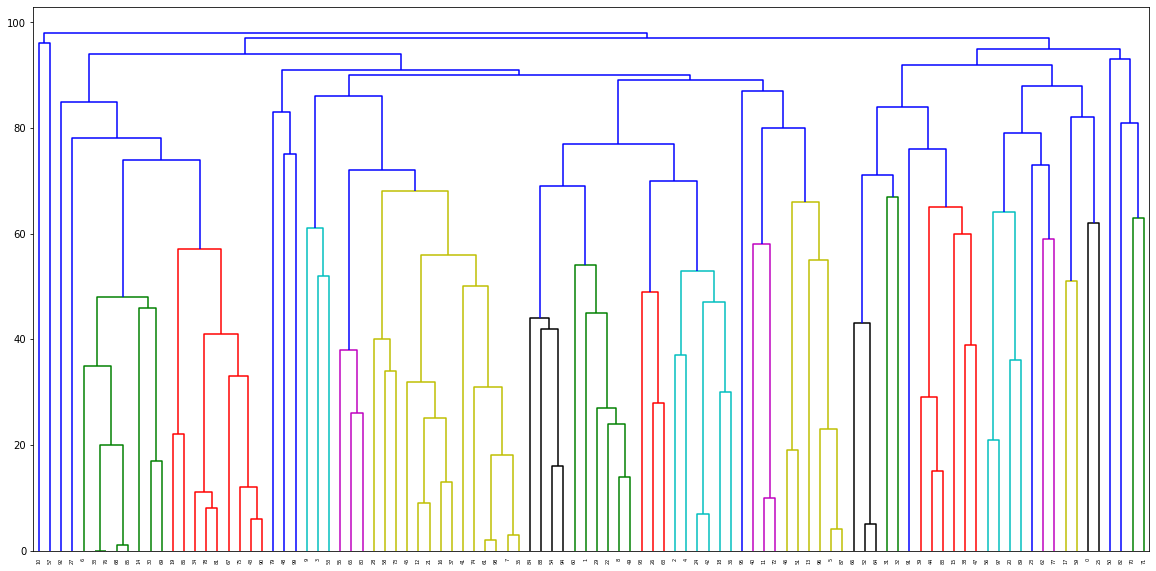

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(20, 10))
plot_dendrogram(clst)

Assign the cluster labels to a column in our original dataframe.

In [15]:
zillow_sub["labels"] = clst.labels_
zillow_sub["labels"].value_counts()

2    71
0    27
3     1
1     1
Name: labels, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
# Know cluster sizes before interpretting!
clst_avgs = zillow_sub.groupby("labels").mean()
clst_avgs.style.background_gradient()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
labels,,,,,,,,,,,,,
0,4.407407,4.481481,4252.851852,2.296296,4.000000,3.000000,844.555556,60515.481481,605.666667,9.296296,1995.888889,1.740741,13837.904444
1,6.500000,5.000000,10188.000000,4.000000,6.000000,8.000000,2204.000000,81022.000000,800.000000,12.000000,2004.000000,2.000000,72020.940000
2,2.746479,3.873239,2524.507042,1.464789,2.450704,2.070423,558.056338,17001.929577,509.732394,7.760563,1978.281690,1.535211,6731.545070
3,8.000000,7.000000,15279.000000,4.000000,8.000000,6.000000,1523.000000,76666.000000,600.000000,21.000000,1994.000000,2.000000,40354.840000


<IPython.core.display.Javascript object>

Interpret the clusters

## DBSCAN Clustering

Links:
* [A cool demo animation](https://www.youtube.com/watch?v=h53WMIImUuc&feature=youtu.be&t=2)
* [Video to try and slow down and discuss the process shown in the animation animation](https://drive.google.com/file/d/1qXsccjEWXYUi1SNJQWRCNrySegjWjnPN/view?usp=sharing)

Perform clustering with [`sklearn.cluster.DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

Assign the labels to the dataframe

Perform clustering with DBSCAN using the distance matrix (with the same `eps` and `min_samples`.

Confirm you get the same results

Interpret the clusters

Change the values of `eps` and `min_samples` and repeat the analysis.